<div align="center">

###### Lab 2

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 2: Predicting Heart Disease with Deep Learning

</div>

### Introduction

In the realm of healthcare, early detection and accurate prediction of diseases play a crucial role in patient care and management. Heart disease remains one of the leading causes of mortality worldwide, making the development of effective diagnostic tools essential. This lab leverages deep learning to predict the presence of heart disease in patients using a subset of 14 key attributes from the Cleveland Heart Disease Database. The objective is to explore and apply deep learning techniques to distinguish between the presence and absence of heart disease based on clinical parameters.

Throughout this lab, you'll engage with the following key activities:
- Use [Pandas](https://pandas.pydata.org) to process the CSV files.
- Use [PyTorch](https://pytorch.org) to build an Artificial Neural Network (ANN) to fit the dataset.
- Evaluate the performance of the trained model to understand its accuracy.

### Attribute Information

1. age: Age of the patient in years
2. sex: (Male/Female)
3. cp: Chest pain type (4 types: low, medium, high, and severe)
4. trestbps: Resting blood pressure
5. chol: Serum cholesterol in mg/dl
6. fbs: Fasting blood sugar > 120 mg/dl
7. restecg: Resting electrocardiographic results (values 0,1,2)
8. thalach: Maximum heart rate achieved
9. exang: Exercise induced angina
10. oldpeak: Oldpeak = ST depression induced by exercise relative to rest
11. slope: The slope of the peak exercise ST segment
12. ca: Number of major vessels (0-3) colored by fluoroscopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversible defect
14. target: target have disease or not (1=yes, 0=no)

### References
- [UCI Heart Disease Data](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data) for the dataset we use in this lab.


## A. Checking and Preprocessing

In [ ]:
import pandas as pd

df = pd.read_csv('heart_dataset_train_all.csv')

df = df.dropna()

# Mapping 'sex' descriptions to numbers
sex_description = {
    'Male': 0,
    'Female': 1,
}
df.loc[:, 'sex'] = df['sex'].map(sex_description)

# Mapping 'cp' (chest pain) descriptions to numbers
pain_description = {
    'low': 0,
    'medium': 1,
    'high': 2,
    'severe': 3
}
df.loc[:, 'cp'] = df['cp'].map(pain_description)

df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,41,0,1,105.0,198.0,0,1.0,168.0,0,0.0,2.0,1,2.0,1.0
1,65,1,0,120.0,177.0,0,1.0,140.0,0,0.4,2.0,0,3.0,1.0
2,44,1,1,130.0,219.0,0,0.0,188.0,0,0.0,2.0,0,2.0,1.0
3,54,1,2,125.0,273.0,0,0.0,152.0,0,0.5,0.0,1,2.0,1.0
4,51,1,3,125.0,213.0,0,0.0,125.0,1,1.4,2.0,1,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,40,1,0,110.0,167.0,0,0.0,114.0,1,2.0,1.0,0,3.0,0.0
269,60,1,0,117.0,230.0,1,1.0,160.0,1,1.4,2.0,2,3.0,0.0
270,64,1,2,140.0,335.0,0,1.0,158.0,0,0.0,2.0,0,2.0,0.0
271,43,1,0,120.0,177.0,0,0.0,120.0,1,2.5,1.0,0,3.0,0.0


#### Converting the DataFrame to a NumPy Array

In [ ]:
import numpy as np

np_data = df.values

split_point = int(np_data.shape[0]*0.7)

np.random.shuffle(np_data)

x_train = np_data[:split_point, :13]
y_train = np_data[:split_point, 13]
x_val = np_data[split_point:, :13]
y_val = np_data[split_point:, 13]

x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int64)
x_val = np.array(x_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.int64)

import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Number of samples in train and validation are 189 and 81.


## B. Defining Neural Networks

In PyTorch, we can use **class** to define our custom neural network architectures by subclassing the `nn.Module` class. This gives our neural network all the functionality it needs to work with PyTorch's other utilities and keeps our implementation organized.

- Neural networks are defined by subclassing `nn.Module`.
- The layers of the neural network are initialized in the `__init__` method.
- The forward pass operations on input data are defined in the `forward` method.

It's worth noting that while we only define the forward pass, PyTorch will automatically derive the backward pass for us, which is used during training to update the model's weights."

In [ ]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(13, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        ).cuda()

    def forward(self, x):
        return self.model(x)

## C. Training the Neural Network

In [ ]:
# Check your GPU status.
!nvidia-smi

Mon Mar 24 14:08:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P0             28W /   70W |     160MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

# 1. 讀取 test dataset
test_data = np.loadtxt('heart_dataset_test.csv', delimiter=',', skiprows=1)  # 如果有header，記得 skiprows=1
x_test = torch.from_numpy(test_data[:, :13]).float()
y_test = torch.from_numpy(test_data[:, 13]).long()
test_dataset = TensorDataset(x_test, y_test)

# 2. 超參數組合
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64, 128]

# 儲存所有實驗結果
results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f'\n>>> Training with lr={lr}, batch_size={batch_size}')

        # 3. 建立 train/val loader（假設你已經有 train_dataset, val_dataset）
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # test 固定 batch_size=1

        # 4. 初始化模型
        model = Model().cuda()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        lr_scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0)

        epochs = 100
        best_val_loss = float('inf')
        best_val_acc = -1

        # 5. 訓練 + 驗證
        for epoch in tqdm(range(epochs)):
            model.train()
            total_loss = 0.0
            train_correct = 0
            total_train_samples = 0

            for features, labels in train_loader:
                features = features.cuda()
                labels = labels.cuda()
                optimizer.zero_grad()

                outputs = model(features)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                train_predicted = outputs.argmax(-1)
                train_correct += (train_predicted == labels).sum().item()
                total_train_samples += labels.size(0)

            lr_scheduler.step()
            avg_train_loss = total_loss / len(train_loader)
            train_accuracy = 100. * train_correct / total_train_samples

            # Validation
            model.eval()
            total_val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for features, labels in val_loader:
                    features = features.cuda()
                    labels = labels.cuda()
                    outputs = model(features)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    predicted = outputs.argmax(-1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
            avg_val_loss = total_val_loss / len(val_loader)
            val_accuracy = 100. * correct / total

            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                best_model_state = model.state_dict()

        # 6. Test
        model.load_state_dict(best_model_state)
        model.eval()
        total_test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for features, labels in test_loader:
                features = features.cuda()
                labels = labels.cuda()
                outputs = model(features)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
                predicted = outputs.argmax(-1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = 100. * correct / total

        # 儲存結果
        results.append({
            'learning_rate': lr,
            'batch_size': batch_size,
            'train_loss': avg_train_loss,
            'train_acc': train_accuracy,
            'val_loss': avg_val_loss,
            'val_acc': best_val_acc,
            'test_loss': avg_test_loss,
            'test_acc': test_accuracy
        })

# 7. 輸出結果
df = pd.DataFrame(results)
print(df)


>>> Training with lr=0.01, batch_size=32


  0%|          | 0/100 [00:00<?, ?it/s]


>>> Training with lr=0.01, batch_size=64


  0%|          | 0/100 [00:00<?, ?it/s]


>>> Training with lr=0.01, batch_size=128


  0%|          | 0/100 [00:00<?, ?it/s]


>>> Training with lr=0.001, batch_size=32


  0%|          | 0/100 [00:00<?, ?it/s]


>>> Training with lr=0.001, batch_size=64


  0%|          | 0/100 [00:00<?, ?it/s]


>>> Training with lr=0.001, batch_size=128


  0%|          | 0/100 [00:00<?, ?it/s]


>>> Training with lr=0.0001, batch_size=32


  0%|          | 0/100 [00:00<?, ?it/s]


>>> Training with lr=0.0001, batch_size=64


  0%|          | 0/100 [00:00<?, ?it/s]


>>> Training with lr=0.0001, batch_size=128


  0%|          | 0/100 [00:00<?, ?it/s]

   learning_rate  batch_size  train_loss  train_acc  val_loss    val_acc  \
0         0.0100          32    0.226297  91.534392  0.705065  77.777778   
1         0.0100          64    0.251459  89.947090  0.645470  76.543210   
2         0.0100         128    0.269447  91.534392  0.581102  76.543210   
3         0.0010          32    0.300177  91.534392  0.562483  77.777778   
4         0.0010          64    0.374298  86.243386  0.631015  74.074074   
5         0.0010         128    0.457016  78.306878  0.600064  71.604938   
6         0.0001          32    0.481816  76.190476  0.618340  70.370370   
7         0.0001          64    0.517416  73.544974  0.583656  76.543210   
8         0.0001         128    0.550066  69.841270  0.609269  74.074074   

   test_loss   test_acc  
0   0.418512  74.193548  
1   0.435006  77.419355  
2   0.455437  80.645161  
3   0.483287  77.419355  
4   0.565790  70.967742  
5   0.636363  67.741935  
6   0.631003  67.741935  
7   0.652993  67.741935  
8   0

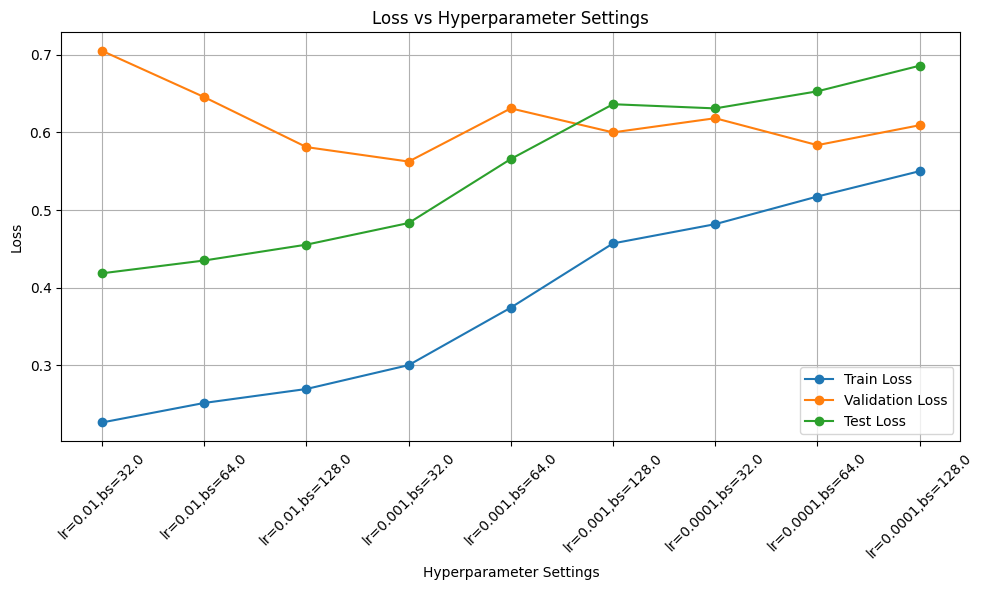

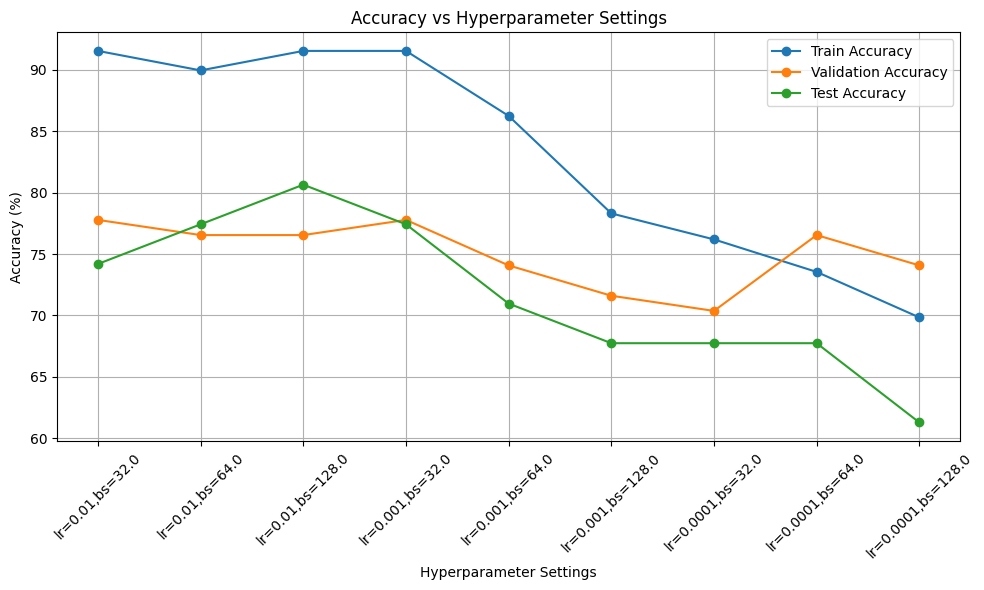

In [ ]:
import matplotlib.pyplot as plt

# 設定圖片尺寸
plt.figure(figsize=(10, 6))

# Loss plot
plt.plot(df.index, df['train_loss'], marker='o', label='Train Loss')
plt.plot(df.index, df['val_loss'], marker='o', label='Validation Loss')
plt.plot(df.index, df['test_loss'], marker='o', label='Test Loss')

plt.xticks(df.index, [f"lr={row['learning_rate']},bs={row['batch_size']}" for _, row in df.iterrows()], rotation=45)
plt.xlabel('Hyperparameter Settings')
plt.ylabel('Loss')
plt.title('Loss vs Hyperparameter Settings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_comparison.png')  # 自動存圖
plt.show()

# Accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['train_acc'], marker='o', label='Train Accuracy')
plt.plot(df.index, df['val_acc'], marker='o', label='Validation Accuracy')
plt.plot(df.index, df['test_acc'], marker='o', label='Test Accuracy')

plt.xticks(df.index, [f"lr={row['learning_rate']},bs={row['batch_size']}" for _, row in df.iterrows()], rotation=45)
plt.xlabel('Hyperparameter Settings')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Hyperparameter Settings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('accuracy_comparison.png')  # 自動存圖
plt.show()